In [ ]:
########################################################################################################################
# Filename: FF_Models_Training.ipynb
#
# Purpose: Multi-label Text-categorization via feed forward neural networks -- Train networks/generate results

# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, scikit-learn, skmultilearn, joblib, os, sys, threshold_learning, matplotlib
########################################################################################################################

# Multilabel Text Classification with Feed Forward Networks

In [75]:
import numpy as np
import pandas as pd
import math
import os
import json
import ast
import random
from joblib import dump, load
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\rober\\OneDrive\\Documents\\Multilabel-Text-Classification\\Deep Learning Models\\FF Models')  ## Set working directory
                                                                                                                      ## to be 'ANN Results'
sys.path.append('../../ThresholdFunctionLearning')    ## Append path to the ThresholdFunctionLearning directory to the interpreters
                                                   ## search path
from threshold_learning import predict_test_labels_binary    ## Import the 'predict_test_labels_binary()' function from the 
from threshold_learning import predict_labels_binary         ## threshold_learning library
sys.path.append('GridSearchAid_FFNetworks')
from FFNN_gridSearch_aid import SizeLayersPows2, createModel

In [76]:
## Set config values
num_epochs = 30
activation_func = 'relu'
output_activation = 'sigmoid'
loss_func = 'binary_crossentropy'
num_layers_list = [3, 5, 7]
learning_rates_list = [0.1, 0.01, 0.001]
path_to_sepPCs_data = '../../Data/tfidf_PC_separable.npz'
path_to_encoded_data = '../../Data/tfidf_encoded_data.npz'
path_to_training_histories_cache = "Training Histories Layers GS"
path_to_sepPC_models = 'Models sepPCs'
path_to_encoded_models = 'Models encoded'

In [3]:
## Load the seperabe PCs training and test data
npzfile = np.load(path_to_sepPCs_data)
X_sepPCs_train = npzfile['X_sepPCs_train']
X_sepPCs_test = npzfile['X_sepPCs_test']
Y_train = npzfile['Y_train'].astype('float64')
Y_test = npzfile['Y_test'].astype('float64')

## Load the autoencoder train/test features
npzfile = np.load(path_to_encoded_data)
encoded_train = npzfile['encoded_train']
encoded_test = npzfile['encoded_test']

## Load the tfidf training and test data
npzfile = np.load("../../Data/tfidf_trainTest_data.npz", allow_pickle = True)
X_tfidfTrain = npzfile['X_tfidfTrain']
X_tfidfTest = npzfile['X_tfidfTest']

# Cross Entropy Models -- Traditional ("Naive") Approach


## Training on Dimension-Reduced Separable PC Vectors

In [20]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(X_sepPCs_train, 
                            num_layers, 
                            X_sepPCs_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = loss_func,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(X_sepPCs_train, Y_train, epochs = num_epochs,
                                  validation_data = (X_sepPCs_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_sepPCs_ce_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [92]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_ce_FF_sepPCs.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

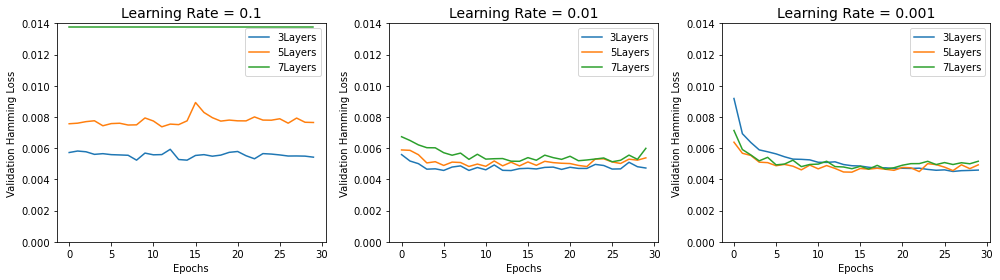

In [62]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.014)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [96]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = path_to_training_histories_cache + "/history_ce_FF_sepPCs.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_sepPCs_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_3_sepPCs_ce_001']
#selected_model.save_weights(path_to_sepPC_models + '/FFNN_best')

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [97]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(encoded_train, 
                            num_layers, 
                            encoded_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = loss_func,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(encoded_train, Y_train, epochs = num_epochs,
                                  validation_data = (encoded_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_encoded_ce_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [103]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_training_histories_cache + "/history_ce_FF_encoded.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

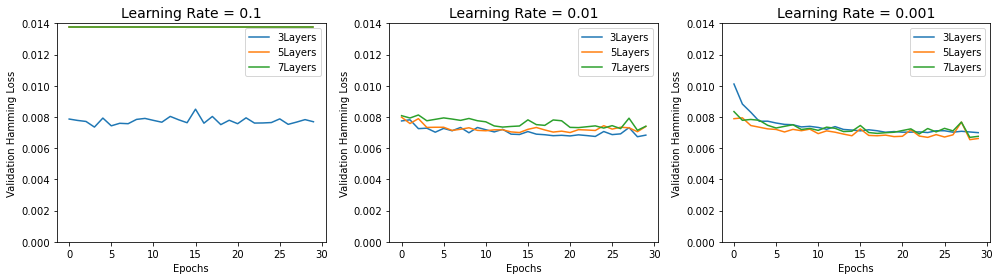

In [104]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{num_layers}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_3_val_hamming_loss, label = str(3) + 'Layers')
ax{i}.plot(model_5_val_hamming_loss, label = str(5) + 'Layers')
ax{i}.plot(model_7_val_hamming_loss, label = str(7) + 'Layers')
ax{i}.set_ylim(0, 0.014)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [105]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = path_to_training_histories_cache + "/history_ce_FF_encoded.npz" 
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        history_name = f"model_{num_layers}_encoded_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_3_encoded_ce_001']
#selected_model.save_weights(path_to_encoded_models + '/FFNN_best')

# BPMLL Models -- "Novel" Approach

## Training on Dimension-Reduced Separable PC Vectors

In [ ]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO READ IN TRAINING HISTORIES)
## Perform grid search over learning rate and model complexity
model_dict = {}
history_dict = {}
history_df_dict = {}
for learning_rate in learning_rates_list:
    for num_layers in num_layers_list:
        model = createModel(X_sepPCs_train, 
                            num_layers, 
                            X_sepPCs_train.shape[0], 
                            Y_train.shape[1], 
                            activation_func = activation_func, 
                            output_activation = output_activation, 
                            loss_func = bp_mll_loss,
                            learning_rate = learning_rate)
    
        tf.random.set_seed(123)
        model_history = model.fit(X_sepPCs_train, Y_train, epochs = num_epochs,
                                  validation_data = (X_sepPCs_test, Y_test), verbose = 0)
        name = f"model_{num_layers}_sepPCs_bpmll_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model
        history_dict[name] = model_history
        history_df_dict[name] = pd.DataFrame(model_history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(model_history.history)')

In [10]:
%%capture
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load models and training histories
model_dict = {}
for num_layers in num_layers_list:
    model = createModel(X_sepPCs_train, 
                        num_layers, 
                        X_sepPCs_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = activation_func, 
                        output_activation = output_activation, 
                        loss_func = bp_mll_loss)
    
    name = f"model_{num_layers}_sepPCs_bpmll"
    model_dict[name] = model

model_3_sepPCs_bpmll = model_dict['model_3_sepPCs_bpmll']
model_5_sepPCs_bpmll = model_dict['model_5_sepPCs_bpmll']
model_7_sepPCs_bpmll = model_dict['model_7_sepPCs_bpmll']
model_3_sepPCs_bpmll.load_weights(path_to_sepPC_models + '/FFNN_3layers_bpmll')
model_5_sepPCs_bpmll.load_weights(path_to_sepPC_models + '/FFNN_5layers_bpmll')
model_7_sepPCs_bpmll.load_weights(path_to_sepPC_models + '/FFNN_7layers_bpmll')

preds_3 = model_3_sepPCs_bpmll.predict(X_sepPCs_test)
preds_5 = model_5_sepPCs_bpmll.predict(X_sepPCs_test)
preds_7 = model_7_sepPCs_bpmll.predict(X_sepPCs_test)

histories = np.load(path_to_training_histories_cache + "/history_bpmll_FF_sepPCs_lr001.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
history_3DF = pd.DataFrame(histories['history_3DF'], columns = history_cols)
history_5DF = pd.DataFrame(histories['history_5DF'], columns = history_cols)
history_7DF = pd.DataFrame(histories['history_7DF'], columns = history_cols)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_25 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_28 (Dense)             (None, 256)               262400    
__________________________

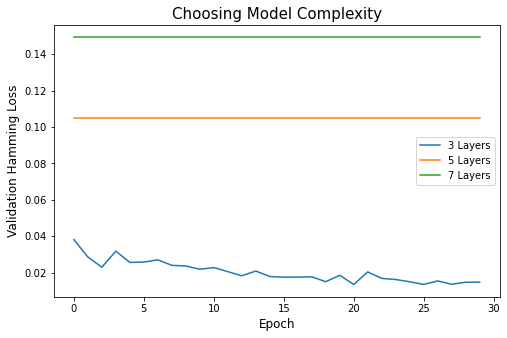

In [11]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.plot(history_7DF['val_hamming_loss'], label = '7 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_3_sepPCs_bpmll.summary()
model_5_sepPCs_bpmll.summary()
model_7_sepPCs_bpmll.summary()

In [6]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = path_to_training_histories_cache + "/history_bpmll_FF_sepPCs_lr001.npz" 
#np.savez_compressed(outfile, history_3DF = history_3DF,
#                             history_5DF = history_5DF,
#                             history_7DF = history_7DF)

#model_3_sepPCs_bpmll.save_weights(path_to_sepPC_models + '/FFNN_3layers_bpmll')
#model_5_sepPCs_bpmll.save_weights(path_to_sepPC_models + '/FFNN_5layers_bpmll')
#model_7_sepPCs_bpmll.save_weights(path_to_sepPC_models + '/FFNN_7layers_bpmll')

## Training on Dimension-Reduced Autoencoder Feature Vectors

In [9]:
%%capture
## (CAUTION: THIS TAKES A WHILE TO RUN. INSTEAD, USE NEXT CELL TO DEFINE MODELS AND READ IN TRAINED PARAMETERS)
## (NOTE: The 7 layer model was too large to store on GitHub -- You can adjust the code in this cell to 
## define & train only the 7-layer network)
## Perform small grid search to choose number of layers
model_dict = {}
history_dict = {}
for num_layers in num_layers_list:
    model = createModel(encoded_train, 
                        num_layers, 
                        encoded_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = activation_func, 
                        output_activation = output_activation, 
                        loss_func = bp_mll_loss)
    
    tf.random.set_seed(123)
    model_history = model.fit(encoded_train, Y_train, epochs = num_epochs,
                              validation_data = (encoded_test, Y_test), verbose = 0)
    name = f"model_{num_layers}_encoded_bpmll"
    model_dict[name] = model
    history_dict[name] = model_history
    
## Convert the training histories to DFs for plotting
history_3 = history_dict['model_3_encoded_bpmll']
history_5 = history_dict['model_5_encoded_bpmll']
history_7 = history_dict['model_7_encoded_bpmll']
history_3DF = pd.DataFrame(history_3.history)
history_5DF = pd.DataFrame(history_5.history)
history_7DF = pd.DataFrame(history_7.history)

model_3_encoded_bpmll = model_dict['model_3_encoded_bpmll']
model_5_encoded_bpmll = model_dict['model_5_encoded_bpmll']
model_7_encoded_bpmll = model_dict['model_7_encoded_bpmll']

In [12]:
%%capture
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load models and training histories
model_dict = {}
for num_layers in num_layers_list:
    model = createModel(encoded_train, 
                        num_layers, 
                        encoded_train.shape[0], 
                        Y_train.shape[1], 
                        activation_func = activation_func, 
                        output_activation = output_activation, 
                        loss_func = bp_mll_loss)
    
    name = f"model_{num_layers}_encoded_bpmll"
    model_dict[name] = model

model_3_encoded_bpmll = model_dict['model_3_encoded_bpmll']
model_5_encoded_bpmll = model_dict['model_5_encoded_bpmll']
model_7_encoded_bpmll = model_dict['model_7_encoded_bpmll']
model_3_encoded_bpmll.load_weights(path_to_encoded_models + '/FFNN_3layers_bpmll')
model_5_encoded_bpmll.load_weights(path_to_encoded_models + '/FFNN_5layers_bpmll')
model_7_encoded_bpmll.load_weights(path_to_encoded_models + '/FFNN_7layers_bpmll')

preds_3 = model_3_encoded_bpmll.predict(encoded_test)
preds_5 = model_5_encoded_bpmll.predict(encoded_test)
preds_7 = model_7_encoded_bpmll.predict(encoded_test)

histories = np.load(path_to_training_histories_cache + "/history_bpmll_FF_encoded_lr001.npz", allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
history_3DF = pd.DataFrame(histories['history_3DF'], columns = history_cols)
history_5DF = pd.DataFrame(histories['history_5DF'], columns = history_cols)
history_7DF = pd.DataFrame(histories['history_7DF'], columns = history_cols)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 1024)              34816     
_________________________________________________________________
dense_37 (Dense)             (None, 90)                92250     
Total params: 127,066
Trainable params: 127,066
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 2048)              69632     
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_40 (Dense)             (None, 256)               262400    
_________________________

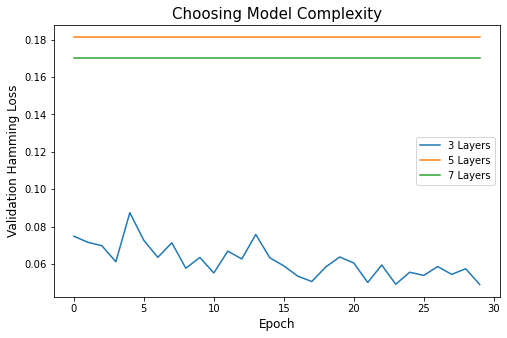

In [13]:
## Visualize the 'val_hamming_loss' histories for each model in a single plot
plt.figure(figsize=(8, 5))
plt.plot(history_3DF['val_hamming_loss'], label = '3 Layers')
plt.plot(history_5DF['val_hamming_loss'], label = '5 Layers')
plt.plot(history_7DF['val_hamming_loss'], label = '7 Layers')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('Choosing Model Complexity', fontsize = 15)
#plt.savefig('Reduced_Dataset_Learning_Rate_01.png')

## Print the model summaries
model_3_encoded_bpmll.summary()
model_5_encoded_bpmll.summary()
model_7_encoded_bpmll.summary()

In [11]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Convert training history to dataframe and write to a .json file 
outfile = path_to_training_histories_cache + "/history_bpmll_FF_encoded_lr001.npz" 
#np.savez_compressed(outfile, history_3DF = history_3DF,
                             history_5DF = history_5DF,
                             history_7DF = history_7DF)

#model_3_encoded_bpmll.save_weights(path_to_encoded_models + '/FFNN_3layers_bpmll')
#model_5_encoded_bpmll.save_weights(path_to_encoded_models + '/FFNN_5layers_bpmll')
#model_7_encoded_bpmll.save_weights(path_to_encoded_models + '/FFNN_7layers_bpmll')